# Set up enviroment

In [17]:
!pip install pmdarima
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import joblib

from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
tokens = ["btc", "eth", "xrp"]
train_test_split = ["721", "622", "811"]

data_source = '/content/drive/My Drive/Report_DBA/final_report/'
processed_output_dir = os.path.join(data_source,  "processing/")

targets = ["Close"]

data_set = {1: "train", 2: "test", 3: "validation"}

model_name = "sarimax"

T = 60 # ----> lookback
TF = 1 # ----> predict
NFeature = 1 # ----> feautures

# working on
token_id = 2
# n_split = 0 # 721
n_split = 1 # 622
# n_split = 2 # 811

In [20]:
%cd $data_source
# !ls

/content/drive/.shortcut-targets-by-id/18gnWYdGzOyKzmDGlJY4vNWNSvTS-3XTk/Report_DBA/final_report


In [21]:
# load scaler
scaler = joblib.load(os.path.join(f"{processed_output_dir}/{tokens[token_id]}/{train_test_split[n_split]}", f"{targets[0]}_train_scalerMinMaxNorm.save"))

# Get raw data

In [22]:
def getData(data_dir = "processing", subset = "train", token_id  = 0):
    df = pd.read_excel(f"{data_dir}/{tokens[token_id]}/{train_test_split[n_split]}/{targets[0]}_{subset}_scaler.xlsx")
    df.drop(columns=["Unnamed: 0"], inplace=True)
    return df

# Define supervised data

In [23]:
def getSupervisedData(T, TF, train, test, val):

    # TRAIN
    series = train.to_numpy()
    X = []
    Y = []
    for t in range(len(series) - T - TF + 1):
      x = series[t:t+T,-1]
      X.append(x)

      y = series[t+T:t+T+TF,-1]
      Y.append(y)
    Xtrain = np.array(X).astype(float)
    Ytrain = np.array(Y).astype(float).reshape(len(Y),)

    # TEST
    series = np.concatenate([train.to_numpy()[-T:],test.to_numpy()])
    X = []
    Y = []
    for t in range(len(series) - T - TF + 1):
      x = series[t:t+T,-1]
      X.append(x)

      y = series[t+T:t+T+TF,-1]
      Y.append(y)
    Xtest = np.array(X).astype(float)
    Ytest = np.array(Y).astype(float).reshape(len(Y),)

    # VAL
    series = np.concatenate([test.to_numpy()[-T:],val.to_numpy()])
    X = []
    Y = []
    for t in range(len(series) - T - TF + 1):
      x = series[t:t+T,-1]
      X.append(x)

      y = series[t+T:t+T+TF,-1]
      Y.append(y)
    Xval = np.array(X).astype(float)
    Yval = np.array(Y).astype(float).reshape(len(Y),)

    return Xtrain,Ytrain, Xtest,Ytest, Xval, Yval

# Build Model

In [24]:
def buildModel(df, y, x):
  arimaModel = pm.auto_arima(y,
                      exogenous = x,
                      m = 7,
                      seasonal=True,
                      test='adf',       # use adftest to find optimal 'd'
                      trace=True,
                      alpha=0.03,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
  return arimaModel

# Start

In [25]:
df_train = getData(subset="train")
df_test = getData(subset="test")
df_val = getData(subset="validation")

In [26]:
Xtrain, Ytrain, Xtest, Ytest, Xval, Yval = getSupervisedData(T, TF, df_train, df_test, df_val)

In [27]:
df_train.shape

(1205, 1)

In [28]:
model = buildModel(df_train, Ytrain, Xtrain )
print(model.summary())

model_location = f"Model/{tokens[token_id]}"

# create folder if not exits
os.makedirs(model_location, exist_ok=True)

# save
joblib.dump(model, f"{model_location}/{model_name}_{train_test_split[n_split]}.pkl")

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=-7028.684, Time=1.17 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-7031.143, Time=0.18 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=-7036.687, Time=1.10 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-7038.751, Time=1.99 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=-7028.315, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=-7029.216, Time=0.31 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=-7031.522, Time=2.01 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=-7043.613, Time=4.78 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=-7041.756, Time=3.75 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=-7045.441, Time=1.62 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=-7039.381, Time=1.75 sec
 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=-7043.580, Time=3.00 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=-7033.448, Time=1.12 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=-7043.623, Time=3.37 sec
 ARIMA(1,1,1)(0,0,2

['Model/xrp/sarimax_622.pkl']

# Test and Visualization

In [29]:
def evaluate(df, title, actual, predict):
  rmse = np.sqrt(mean_squared_error(actual, predict))
  mae = mean_absolute_error(actual, predict)
  mape = mean_absolute_percentage_error(actual, predict)

  df[f"rmse_{title}"].append(rmse)
  df[f"mae_{title}"].append(mae)
  df[f"mape_{title}"].append(mape)
  return df


In [30]:
# load model to predict
model = joblib.load(f"Model/{tokens[token_id]}/{model_name}_{train_test_split[n_split]}.pkl")
model

ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 0, 2, 7),
      suppress_warnings=True)

In [31]:
metrics_df = {
    "rmse_train": [],
    "mae_train": [],
    "mape_train": [],
    "rmse_test": [],
    "mae_test": [],
    "mape_test": [],
    "rmse_val": [],
    "mae_val": [],
    "mape_val": [],
}
# Dự đoán trên tập huấn luyện
y_pred_train = model.predict_in_sample()
y_pred_test = model.predict(n_periods=len(Ytest), exogenous=Xtest)
y_pred_val = model.predict(n_periods=len(Yval), exogenous=Xval)

# inverse transform TRAIN
pred_train = scaler.inverse_transform(y_pred_train.reshape(1, -1))
y_true_train = scaler.inverse_transform(Ytrain.reshape(1, -1))

# inverse transform TEST
pred_test = scaler.inverse_transform(y_pred_test.reshape(1, -1))
y_true_test = scaler.inverse_transform(Ytest.reshape(1, -1))

# inverse transform VAL
pred_val = scaler.inverse_transform(y_pred_val.reshape(1, -1))
y_true_val = scaler.inverse_transform(Yval.reshape(1, -1))

metrics_df = evaluate(metrics_df, "train", y_true_train, pred_train)
metrics_df = evaluate(metrics_df, "test", y_true_test, pred_test)
metrics_df = evaluate(metrics_df, "val", y_true_val, pred_val)

metrics_df = pd.DataFrame(metrics_df)

metrics_folder = f"metrics/{tokens[token_id]}"
os.makedirs(metrics_folder, exist_ok=True)
metrics_df.to_excel(f"{metrics_folder}/{model_name}_{train_test_split[n_split]}.xlsx")
metrics_df

,rmse_train,mae_train,mape_train,rmse_test,mae_test,mape_test,rmse_val,mae_val,mape_val
0,0.037622,0.017979,0.030395,1.233567,1.085397,0.480587,2.408115,2.37499,2.027878


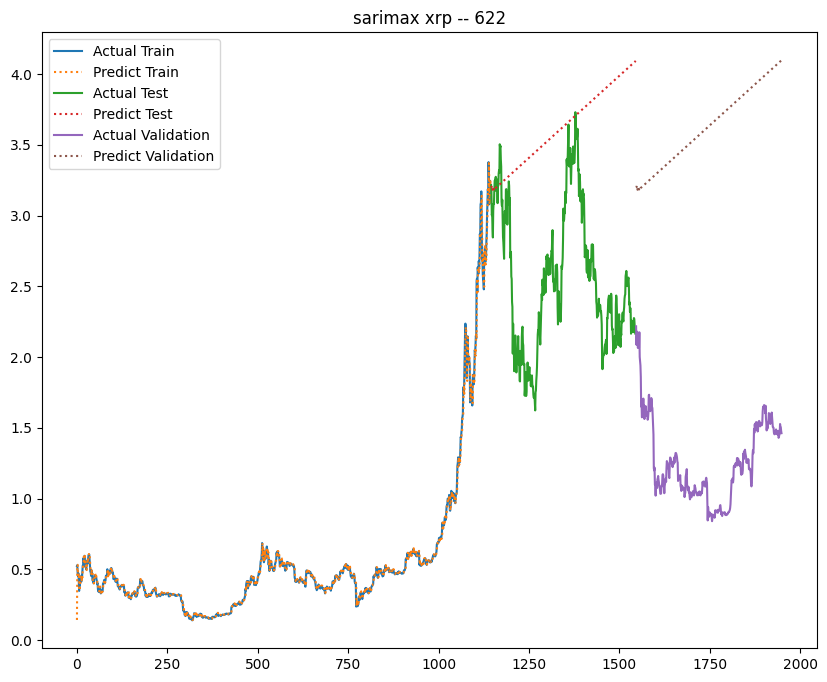

In [32]:
color_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

plt.figure(figsize=(10, 8))

# train
train_range = range(0, len(y_true_train.squeeze()))
plt.plot([*train_range], y_true_train.squeeze(), label="Actual Train", color = color_palette[0])
plt.plot([*train_range], pred_train.squeeze(), label="Predict Train", linestyle="dotted", color = color_palette[1])

# test
test_range = range(train_range[-1] + 1, train_range[-1] + 1 + len(y_true_test.squeeze()))
plt.plot([*test_range], y_true_test.squeeze(), label="Actual Test", color=color_palette[2])
plt.plot([*test_range], pred_test.squeeze(), label="Predict Test", linestyle="dotted", color=color_palette[3])

# val
val_range = range(test_range[-1] + 1, test_range[-1] + 1 + len(y_true_val.squeeze()))
plt.plot([*val_range], y_true_val.squeeze(), label="Actual Validation", color=color_palette[4])
plt.plot([*val_range], pred_val.squeeze(), label="Predict Validation", linestyle="dotted",color=color_palette[5])

plt.legend()
plt.title(f"{model_name} {tokens[token_id]} -- {train_test_split[n_split]}")

save_folder = f"Figures/{tokens[token_id]}"
os.makedirs(f"{save_folder}", exist_ok=True)
plt.savefig(f"{save_folder}/{model_name}_{train_test_split[n_split]}.png")
plt.show()